# Deep Q Networks
前面我们介绍了强化学习中的 q-learning，我们知道对于 q-learning，我们需要使用一个 Q 表来存储我们的状态和动作，每次我们使用 agent 不断探索环境来更新 Q 表，最后我们能够根据 Q 表中的状态和动作来选择最优的策略。但是使用这种方式有一个很大的局限性，如果在现实生活中，情况就会变得非常的复杂，我们可能有成千上万个 state，甚至是无穷无尽有可能是无穷无尽的 state，对于这种情况，我们不可能将所有的 state 都用 Q 表来存储，那么我们该如何解决这个问题呢？

一个非常简单的办法就是使用深度学习来解决这个问题，所以出现了一种新的网络，叫做 Deep Q Networks，将 Q learning 和 神经网络结合在了一起，对于每一个 state，我们都可以使用神经网络来计算对应动作的值，就不在需要建立一张表格，而且网络更新比表格更新更有效率，获取结果也更加高效。

![](https://ws4.sinaimg.cn/large/006tKfTcgy1fni66at6jbj30xo0g1jut.jpg)

下面我们使用 open ai gym 环境中的 CartPole 来尝试实现一个简单的 DQN。

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import gym
import numpy as np
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


定义一些超参数

In [2]:
batch_size = 32
lr = 0.01
epsilon = 0.9
gamma = 0.9
target_replace_iter = 100
memory_capacity = 2000

在这里，我们用`CartPole`游戏作为例子给大家展示强化学习
首先我们通过 gym.make 获得 CartPole 游戏的环境

In [3]:
env = gym.make('CartPole-v0')

这个游戏由一根可以水平移动的底座和可以绕轴转动的杆组成，游戏的目的就是观察杆的位置，通过操作底座水平向左或者是向右移动来让杆在屏幕范围内尽量不掉下来，非常简单的一个游戏
<img src="http://7xkmdr.com1.z0.glb.clouddn.com/cp_1.gif">

gym 提供了可视化的过程, 我们可以大概感受一下它的难度

In [5]:
# 初始化环境
env.reset()
rewards = []

# 玩 100 次游戏
for _ in range(100):
    # 渲染动画
    env.render()
    
    # 随机选择一个动作
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    
    # 如果游戏结束,进入下一个
    if done:
        rewards = []
        env.reset()

NameError: name 'base' is not defined

In [6]:
# 关闭窗口
env.close()

我们可以看看这个游戏的状态数和动作数

In [7]:
# 这一步用来方便后面处理，没有的话很多函数无法使用
env = env.unwrapped
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

In [8]:
print('number of actions are: {}'.format(n_actions))
print('number of states are: {}'.format(n_states))

number of actions are: 2
number of states are: 4


在这里，通过这里可以看到，这个环境的观测的 4 个值分别是板的位置，板的速度，杆的角度以及杆顶端的速度，我们能够采取的动作就是 2 个，分别是向左移动杆和向右移动杆。

本质上，我们其实可以不用关心状态到底是什么，这些状态都可以作为神经网络的输入，输出就是每个动作的 value，可以让神经网络自己学会建立一个类似 Q 表的东西。

In [9]:
import tensorflow.contrib.slim as slim

In [10]:
def q_net(inputs, hidden=50, scope='q_net', reuse=None):
    """2层简单全连接神经网络
    """
    with tf.variable_scope(scope, reuse=reuse):
        # 我们用标准差为 0.1 的正态分布去初始化全连接层
        with slim.arg_scope([slim.fully_connected], weights_initializer=tf.random_normal_initializer(stddev=0.1)):
            net = slim.fully_connected(inputs, hidden, activation_fn=tf.nn.relu, scope='fc1')
            net = slim.fully_connected(net, n_actions, activation_fn=None, scope='fc2')
            
            return net

接下来我们定义一个 DQN 的过程作为一个类，在这个类中，我们会定义 dqn 的学习过程，dqn 的更新过程和之前讲个 q learning 的过程是很相同的

![](https://ws1.sinaimg.cn/large/006tNc79ly1fnhl68e9spj30ek0biwfw.jpg)

上图中有两个网络，第一个网络叫做 action-value function Q，还有一个网络叫做 target action-value $\hat{Q}$.

第一个网络可以称为 eval net，第二个网络叫做 target net。

eval net 每一步都更新参数，而 target net 每过 C 步才更新一次，更新地方式是直接将 eval net 的参数复制到 target net 上。

为什么要学习两个网络而不学习一个网络呢？因为 DQN 希望每次更新能够有一定的时间去探索周围的环境而得到更多的信息再来更新，在游戏中的过程是一个时间序列，所以得到的信息是有着时间依赖关系，每次都直接使用序列信息进行更新并不能得到好的结果，所以我们就采用滞后更新的方式，每隔 C 步才真正更新一次参数。

DQN 的学习过程也非常简单，我们使用 eval net 作为估计动作的 value，使用 target net 得到动作实际的 value，我们希望估计的 value 能够等于实际的 value，所以可以使用 mse 来作为 loss 函数就可以了。

下面我们来实现整个过程

In [11]:
# 接受由游戏传入的状态
input_state = tf.placeholder(tf.float32, [None, n_states,], name='input_state')

# 定义 eval_net
q_eval = q_net(input_state, scope='eval_net')

# 定义 target_net
q_next = q_net(input_state, scope='target_net')

# 先定义好一个和 eval_net 输出相同的占位符，接收 Bellman Equation 的右边项
q_target = tf.placeholder(tf.float32, [None, n_actions], name='Q_target')

# 记录当前学习的步数
learn_step_counter = 0

# 定义一个状态的记忆，他可以记录之前玩过的状态和结果，帮助我们从之前玩过的游戏中学习
# 它由4个元素构成，起始状态，采取的动作，计算的奖励，采取这个动作之后的状态
# 状态的长度为 n_state，其余两个都是标量
memory = np.zeros((memory_capacity, n_states * 2 + 2))

# 记录需要存储的记忆下标
memory_counter = 0

定义`loss`

In [12]:
with tf.variable_scope('loss'):
    loss = tf.reduce_mean(tf.losses.mean_squared_error(q_target, q_eval))

定义训练

In [13]:
with tf.variable_scope('train'):
    train_op = tf.train.RMSPropOptimizer(lr).minimize(loss)

我们像`Q-learning`中一样，需要有一个选择动作的方法

In [14]:
def choose_action(q_eval, s):
    """选择动作
    Arguments:
      q_eval: eval_net 输出的每个动作的 value
      s: 当前的状态
    Return:
      action: 选择的动作
    """
    def cond_true():
        # 在网络输出的动作 value 中挑选最大 value 的动作
        action = tf.argmax(q_eval, axis=-1, output_type=tf.int32, name='greedy_choice')
        return action
    def cond_false():
        # 随机选择一个动作
        action = tf.random_uniform((), minval=0, maxval=n_actions, dtype=tf.int32, name='random_choice')
        return action
    with tf.variable_scope('choose_action'):
        # 贪心算法，以一定概率随机选择新动作，否则从网络输出结果中找到答案
        dice = tf.random_uniform((), minval=0, maxval=1, dtype=tf.float32, name='dice')
        action = tf.cond(tf.less(dice, epsilon), cond_true, cond_false, name='action')
    
    return action

In [15]:
chosen_action = choose_action(q_eval, input_state)

在`DQN`算法中，我们需要存储过去的记忆，以便于后面的学习

In [16]:
def store_transition(s, a, r, s_):
    """存储记忆
    Arguments:
      s: 当前状态
      a: 采取的动作
      r: 采取动作后的奖励
      s_: 采取动作后的状态
    """
    # 通过`global`关键字改变全局变量的值
    global memory, memory_counter
    
    # 将参数整合成一个记忆
    transition = np.hstack((s, [a, r], s_))
    
    # 采用循环替代的方法避免记忆过多历史
    index = memory_counter % memory_capacity
    
    # 将当前记忆写入总记忆中
    memory[index, :] = transition
    memory_counter += 1

前面说到，我们需要间隔一定的步长将一直在更新的`eval_net`网络参数值赋值给`target_net`对应网络参数，相当于是手动更新`target_net`网络参数，在这里，我们就利用名称替换的方法去定义这样一个更新操作

In [17]:
# 找到所有需要更新的 target_net 网络参数
target_net_params = tf.model_variables('target_net')

In [18]:
def update(target_net_params, graph, target_net_scope='target_net', eval_net_scope='eval_net'):
    """更新`target_net`参数
    Arguments:
      target_net_params: target_net 所有网络参数列表
      graph: 当前的 tf 图
      target_net_scope: target_net 网络参数的参数域
      eval_net_scope: eval_net 网络参数的参数域
    Return:
      update_op: 更新 op
    """
    update_ops = []
    with tf.variable_scope('update_target'):
        for var in target_net_params:
            # 用 eval_net_scope 去代替 target_net_params 的参数名称
            eval_var_name = var.name.replace(target_net_scope, eval_net_scope)
            
            # 通过 graph 来获得 eval_net 对应变量
            eval_var = graph.get_tensor_by_name(eval_var_name)
            
            # 用 eval_var 去更新 var
            update_ops.append(var.assign(eval_var))
            
        update_op = tf.group(*update_ops, name='update_target')
    
    return update_op

In [19]:
# 获得当前默认图
graph = tf.get_default_graph()
update_op = update(target_net_params, graph)

下面来到我们最关键的学习环节，整个学习过程在之前大家应该有了一个初步的印象，就是希望`eval_net`能够像`Q-table`一样模拟出在当前状态下采取某个动作的`Q`值，也就是 $eval\_net(state)=r+\gamma\ max(target\_net(next\_state))$. 

我们要做的就是从记忆中抽取一些经历，每个经历都有起始状态，采取的动作，获得的奖励，下一个状态。如果我们对每一个经历都能够使得上面的等式近似成立就完成目标了。

这里有一个小细节，每一段经历中只有一个动作，而我们`eval_net`的输出的是所有动作的`Q`值，因此在学习的过程中我们默认其他动作都是完全正确的，只更新这一个动作。

In [20]:
def learn(sess, input_state, q_eval, q_next, q_target, train_op, loss_op, update_target_op):
    global learn_step_counter
    
    # 间隔步数将 eval_net 的参数复制到 target_net 上
    if learn_step_counter % target_replace_iter == 0:
        sess.run(update_target_op)
    learn_step_counter += 1
    
    # 随机从记忆中抽取经历
    sample_index = np.random.choice(memory_capacity, batch_size)
    b_memory = memory[sample_index, :]
    
    # 当前步状态
    b_s = b_memory[:, :n_states]
    
    # 当前采取的动作
    b_a = b_memory[:, n_states].astype(np.int32)
    
    # 当前采取动作后的奖励
    b_r = b_memory[:, n_states + 1]
    
    # 采取动作后的状态
    b_s_ = b_memory[:, -n_states:]
    
    # 用 eval_net 评估当前动作后所有可能动作的 Q 值
    q_eval_values = sess.run(q_eval, feed_dict={input_state: b_s})
    
    # 复制 q_eval_values 到 q_target_values 中
    # 此时 q_target 和 q_eval 完全相等
    q_target_values = q_eval_values.copy()
    
    # 用 target_net 获得下一个状态所有可能动作的 Q 值
    q_next_values = sess.run(q_next, feed_dict={input_state: b_s_})
    
    # 依据 Bellman Equation 建立 q_target 在记忆中动作 b_a下的值
    
    batch_indices = np.arange(batch_size)
    q_target_values[batch_indices, b_a] = b_r + gamma * q_next_values.max(1)
    
    # 反向传播
    _, this_loss = sess.run([train_op, loss_op], feed_dict={q_target: q_target_values, input_state: b_s})
    
    return this_loss

下面开始训练这个`agent`

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [22]:
print('collecting experience ...')
all_reward = []
for i_episode in range(300):
    s = env.reset()
    reward = 0
    while True:
        # 获取当前状态随机选择的动作
        a = sess.run(chosen_action, feed_dict={input_state: [s]})
        a = np.squeeze(a)
        
        # 环境采取动作得到的结果
        s_, r, done, info = env.step(a)
        
        # 修改奖励以便更快收敛
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2
        
        # 存储记忆
        store_transition(s, a, r, s_)
        
        reward += r
        
        # 记忆收集足够开始学习
        if memory_counter > memory_capacity:
            # 下面这一行可以实时看到训练过程中,我们的 agent 是如何一步步进步的
            # 但是耗时非常长,如果感兴趣的话可以取消下面这一行的注释
            # env.render()
            this_loss = learn(sess, input_state, q_eval, q_next, q_target, train_op, loss, update_op)
            if done:
                print('Ep: {} | reward: {:.3f}'.format(i_episode, round(reward, 3)))
                all_reward.append(reward)
                break

        if done:
            break
        s = s_

collecting experience ...
Ep: 60 | reward: 6.148
Ep: 61 | reward: 47.560
Ep: 62 | reward: 54.196
Ep: 63 | reward: 46.928
Ep: 64 | reward: 32.189
Ep: 65 | reward: 140.913
Ep: 66 | reward: 125.608
Ep: 67 | reward: 511.331
Ep: 68 | reward: 84.113
Ep: 69 | reward: 52.731
Ep: 70 | reward: 148.854
Ep: 71 | reward: 110.133
Ep: 72 | reward: 92.012
Ep: 73 | reward: 240.542
Ep: 74 | reward: 113.561
Ep: 75 | reward: 65.462
Ep: 76 | reward: 94.513
Ep: 77 | reward: 100.471
Ep: 78 | reward: 214.232
Ep: 79 | reward: 55.808
Ep: 80 | reward: 119.773
Ep: 81 | reward: 684.125
Ep: 82 | reward: 166.297
Ep: 83 | reward: 311.433
Ep: 84 | reward: 310.393
Ep: 85 | reward: 228.189
Ep: 86 | reward: 206.277
Ep: 87 | reward: 393.544
Ep: 88 | reward: 126.985
Ep: 89 | reward: 644.794
Ep: 90 | reward: 331.352
Ep: 91 | reward: 132.168
Ep: 92 | reward: 301.265
Ep: 93 | reward: 174.950
Ep: 94 | reward: 192.934
Ep: 95 | reward: 134.680
Ep: 96 | reward: 207.271
Ep: 97 | reward: 363.155
Ep: 98 | reward: 407.869
Ep: 99 | re

接着我们看一下`loss`曲线的变化

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

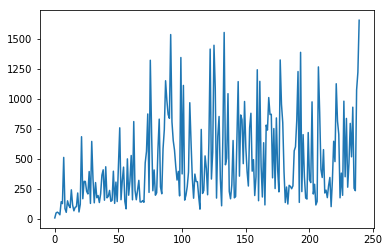

In [24]:
plt.plot(all_reward)

我们画出 reward 的曲线，可以发现奖励在不断变多，说明我们的 agent 学得越来越好

最后我们再来看看`agent`通过训练后的游戏水平吧

In [25]:
s = env.reset()
reward = 0
while True:
    env.render()
    # 通过 q_next 获得当前状态下所有动作的 Q 值
    Qs = sess.run(q_next, feed_dict={input_state: [s]})
    
    # 获得最大 value 的 action
    action = np.argmax(Qs)

    # 环境采取动作得到的结果
    s_, r, done, info = env.step(action)
    
    reward += r
    
    if done:
        break
        
    s = s_
    
print('agent rewad: {:.3f}'.format(reward))

NameError: name 'base' is not defined

In [26]:
env.render(close=True)

TypeError: render() got an unexpected keyword argument 'close'